<a href="https://colab.research.google.com/github/dimi-fn/Spotify-Songs/blob/master/Spotify_Songs_Popularity_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries for data analysis and manipulation
import pandas as pd
import numpy as np

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To ignore potential useless warnings from Scipy (SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# to make this notebook's output identical at every run
np.random.seed(42)

In [3]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

> Inserting the dataset for regression and classification (the split between train and test set is already done).

In [5]:
downloaded = drive.CreateFile({'id':'1faxDrc-DqcciP0PghJbJJts9CRa0bL82'}) 
downloaded.GetContentFile('CS98XClassificationTest.csv') 
classification_test = pd.read_csv('CS98XClassificationTest.csv') 

downloaded = drive.CreateFile({'id':'1TQq8nRRdowS_aULA1SKviqAisw9NWIUd'}) 
downloaded.GetContentFile('CS98XClassificationTrain.csv') 
classification_train = pd.read_csv('CS98XClassificationTrain.csv') 

downloaded = drive.CreateFile({'id':'1tmBD1ct5ig0UF7iIPmcM0MqDwJpYvtpo'}) 
downloaded.GetContentFile('CS98XRegressionTest.csv') 
regression_test = pd.read_csv('CS98XRegressionTest.csv') 

downloaded = drive.CreateFile({'id':'1Zgg12bV-xXozSRI5Kj4631gwbBe2K8By'}) 
downloaded.GetContentFile('CS98XRegressionTrain.csv') 
regression_train = pd.read_csv('CS98XRegressionTrain.csv') 

# Regression Task
### The regression task is about building a model which predicts the popularity of a song, hence:

> Model should learn from the data and be able to predict the popularity of a song given other metrics. It is a supervised learning task since we are given labelled training examples. It is also a multiple regression problem, since we are going to use multiple features which will help the model make predictions about the popularity of a song. Furthermore, it s a univariate regression problem (not multivariate) because we are only trying to predict a single feature (i.e. popularity) for each song. Lastly, this is batch learning (not online learning) since we do not have flow of data coming from external source.


## Exploration of the dataset

> Getting the shape and the 5 first rows:

In [6]:
regression_train.shape

(453, 15)

In [7]:
regression_test.shape # we can understand that the split of test and test set was 80/20 (453+114=567 rows totally)

(114, 14)

In [8]:
regression_train.head()

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77
3,4,Woman in Love,Barbra Streisand,adult standards,1980,170,28,47,-16,13,33,232,25,3,67
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,glam rock,1973,121,47,56,-8,15,40,193,45,3,63


In [9]:
regression_test.head()

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch
0,454,Pump It,The Black Eyed Peas,dance pop,2005,154,93,65,-3,75,74,213,1,18
1,455,"Circle of Life - From ""The Lion King""/Soundtra...",Elton John,glam rock,1994,161,39,30,-15,11,14,292,26,3
2,456,We Are The Champions - Remastered 2011,Queen,glam rock,1977,64,46,27,-7,12,18,179,38,3
3,457,Insomnia - Radio Edit,Faithless,big beat,2010,127,92,71,-9,37,53,216,6,4
4,458,This Eve of Parting,John Hartford,appalachian folk,2018,115,46,56,-12,21,34,153,18,3


> Information about the features of the dataset:

>> We notice there are 15 columns:
- 3 of them (title, artist, top genre) with categorical values
- the rest 12 columns contain numemical values
- 'pop', i.e. song's popularity, is the target value (label)
- the other 14 attributes can be used as predictors

In [10]:
regression_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   top genre  438 non-null    object
 4   year       453 non-null    int64 
 5   bpm        453 non-null    int64 
 6   nrgy       453 non-null    int64 
 7   dnce       453 non-null    int64 
 8   dB         453 non-null    int64 
 9   live       453 non-null    int64 
 10  val        453 non-null    int64 
 11  dur        453 non-null    int64 
 12  acous      453 non-null    int64 
 13  spch       453 non-null    int64 
 14  pop        453 non-null    int64 
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


In [11]:
# summary statistics for numerical features

regression_train.describe()

,Id,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000
mean,227.000000,1991.443709,118.399558,60.070640,59.565121,-8.836645,17.757174,59.465784,226.278146,32.982340,5.660044,60.743929
std,130.914094,16.776103,25.238713,22.205284,15.484458,3.577187,13.830300,24.539868,63.770380,29.530015,5.550581,13.470083
min,1.000000,1948.000000,62.000000,7.000000,18.000000,-24.000000,2.000000,6.000000,98.000000,0.000000,2.000000,26.000000
25%,114.000000,1976.000000,100.000000,43.000000,49.000000,-11.000000,9.000000,42.000000,181.000000,7.000000,3.000000,53.000000
50%,227.000000,1994.000000,119.000000,63.000000,61.000000,-8.000000,13.000000,61.000000,223.000000,24.000000,4.000000,63.000000
75%,340.000000,2007.000000,133.000000,78.000000,70.000000,-6.000000,23.000000,80.000000,262.000000,58.000000,6.000000,71.000000
max,453.000000,2019.000000,199.000000,100.000000,96.000000,-1.000000,93.000000,99.000000,511.000000,100.000000,47.000000,84.000000


> Exploration of the categorical attributes (title, artist, top genre):

In [12]:
regression_train['title'].nunique()


451

In [13]:
regression_train['artist'].nunique() # totally 345 artists

345

In [14]:
regression_train['top genre'].nunique() # totally 86 top genres

86

In [15]:
# top 10 most popular songs
top_10_popular=regression_train.sort_values(by=["pop"], ascending=False).head(10)

In [16]:
top_10_popular

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
294,295,Bohemian Rhapsody - 2011 Mix,Queen,glam rock,1975,71,40,41,-10,30,22,354,27,5,84
234,235,The Scientist,Coldplay,permanent wave,2002,146,44,56,-7,11,21,310,73,2,83
263,264,Africa,TOTO,album rock,1982,93,37,67,-18,5,73,296,26,3,83
337,338,Here Comes The Sun - Remastered 2009,The Beatles,british invasion,1969,129,54,56,-10,18,39,186,3,3,82
162,163,Another One Bites The Dust - Remastered 2011,Queen,glam rock,1980,110,53,93,-6,16,75,215,11,16,82
427,428,Numb,Linkin Park,alternative metal,2003,110,86,50,-4,64,24,186,0,4,81
229,230,Fix You,Coldplay,permanent wave,2005,138,42,21,-9,11,12,296,16,3,81
374,375,Rocket Man (I Think It's Going To Be A Long Lo...,Elton John,glam rock,1972,137,53,60,-9,9,34,282,43,3,81
441,442,Break My Stride,Matthew Wilder,new wave pop,1983,110,59,92,-11,9,83,184,20,6,81
346,347,I Wanna Dance with Somebody (Who Loves Me),Whitney Houston,dance pop,1987,119,82,71,-9,9,87,291,21,5,80


## Visualisation of the dataset

In [17]:
# For visualising distributional values
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


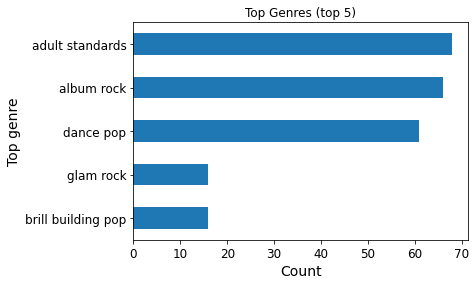

In [18]:

regression_train["top genre"].value_counts().nlargest(5).sort_values(ascending=True).plot.barh()
plt.ylabel("Top genre")
plt.xlabel("Count")
plt.title("Top Genres (top 5)")
plt.show()

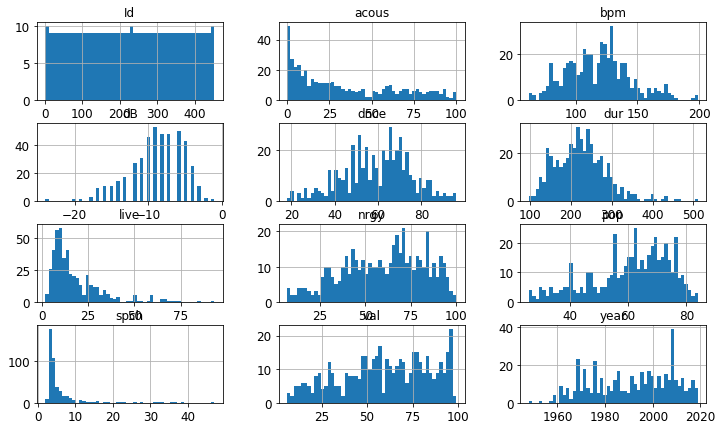

In [19]:
# Plot histograms 
%matplotlib inline
import matplotlib.pyplot as plt

regression_train.hist(bins=50, figsize=(12,7))
plt.show()

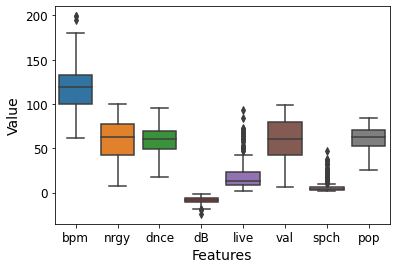

In [20]:
# Plot boxplot of particular feautures
regression_train_boxplot= regression_train[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'spch', 'pop']]
sns.boxplot(data=regression_train_boxplot)
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

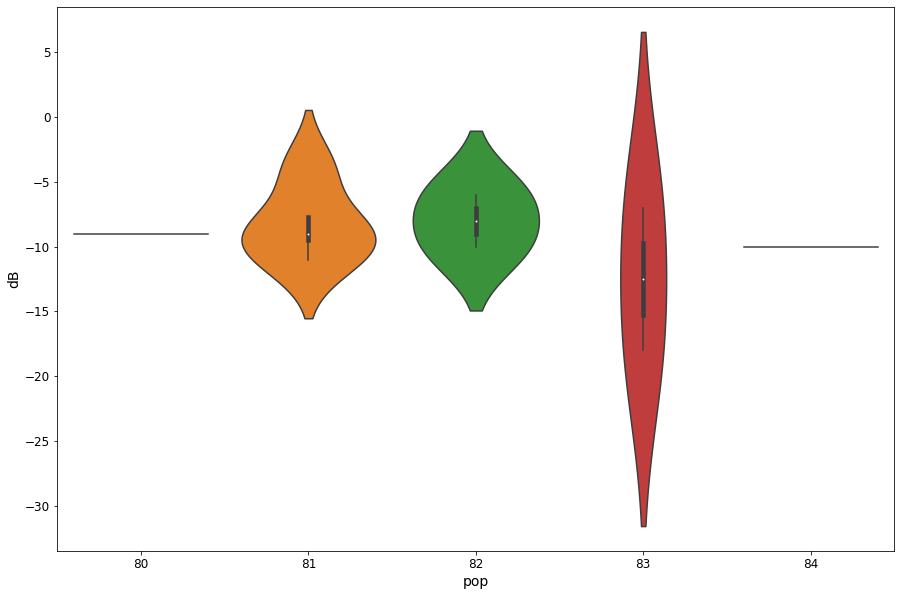

In [21]:
# violin plot between popularity and loudness regarding the top 10 popular songs
plt.figure(figsize=(15,10))
sns.violinplot(x= "pop", y="dB", data= top_10_popular)
plt.show()




>Heatmap of the dataset:


>>The darker the colour(closest to 1), the stronger is the correlation. Here we notice that popularity has strong correlation with energy(nrgy), danceability(dnce), loudness(dB) (and duration, but probably not important):

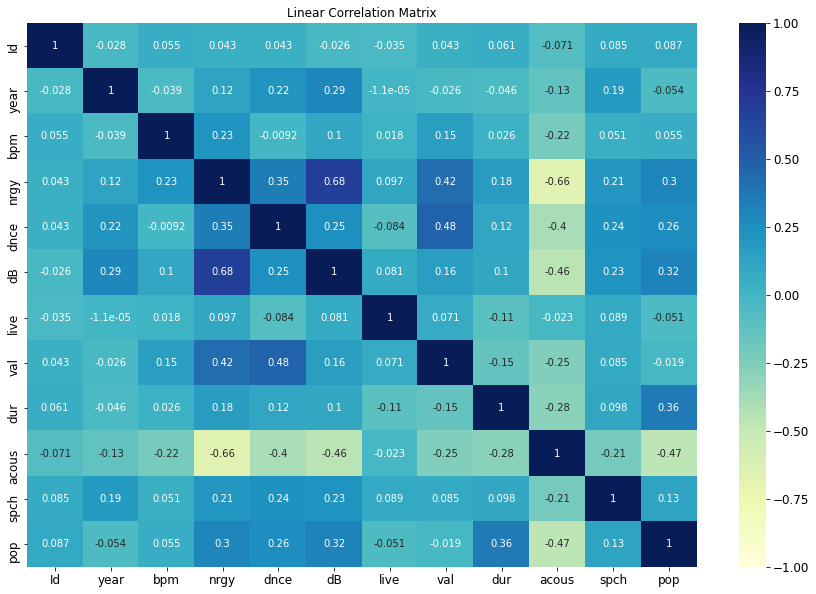

In [22]:
# Plot linear correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(regression_train.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('Linear Correlation Matrix')
plt.show()

> Fitting linear lines between the numerical attributes which seemed to have strong correlation in heatmap

[ 0.18428789 49.67363777]


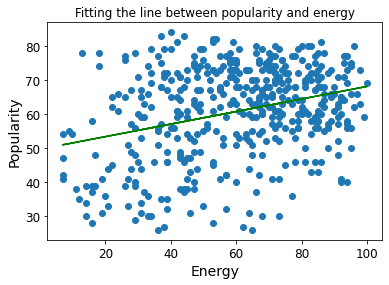

[ 1.19312839 71.28718085]


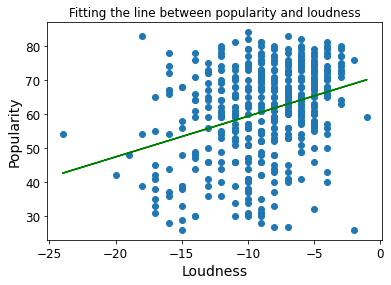

[ 0.22501942 47.34062005]


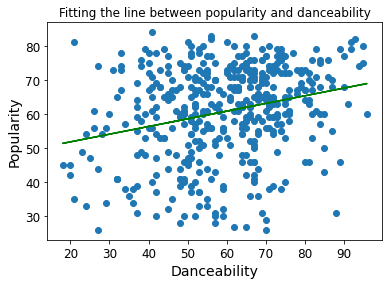

[ 0.07673189 43.38117924]


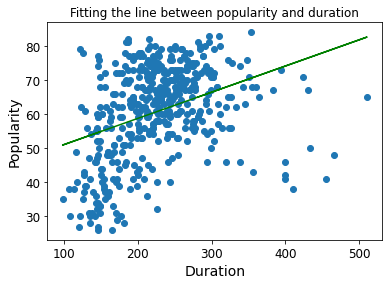

In [23]:
'''
Fit line between popoluarity and energy
'''
fig, ax = plt.subplots() 
fit = np.polyfit(regression_train['nrgy'], regression_train['pop'], deg=1)
print(fit)
ax.plot(regression_train['nrgy'], fit[0] * regression_train['nrgy'] + fit[1], color='green')
ax.scatter(regression_train['nrgy'],regression_train['pop'])
plt.xlabel("Energy")
plt.ylabel("Popularity") 
plt.title('Fitting the line between popularity and energy')
plt.show()

'''
Fit line between popoluarity and loudness
'''
fig, ax = plt.subplots() 
fit = np.polyfit(regression_train['dB'], regression_train['pop'], deg=1)
print(fit)
ax.plot(regression_train['dB'], fit[0] * regression_train['dB'] + fit[1], color='green')
ax.scatter(regression_train['dB'],regression_train['pop'])
plt.xlabel("Loudness")
plt.ylabel("Popularity") 
plt.title('Fitting the line between popularity and loudness')
plt.show()


'''
Fit line between popoluarity and danceability
'''
fig, ax = plt.subplots() 
fit = np.polyfit(regression_train['dnce'], regression_train['pop'], deg=1)
print(fit)
ax.plot(regression_train['dnce'], fit[0] * regression_train['dnce'] + fit[1], color='green')
ax.scatter(regression_train['dnce'],regression_train['pop'])
plt.xlabel("Danceability")
plt.ylabel("Popularity") 
plt.title('Fitting the line between popularity and danceability')
plt.show()

'''
Fit line between popoluarity and duration
'''
fig, ax = plt.subplots() 
fit = np.polyfit(regression_train['dur'], regression_train['pop'], deg=1)
print(fit)
ax.plot(regression_train['dur'], fit[0] * regression_train['dur'] + fit[1], color='green')
ax.scatter(regression_train['dur'],regression_train['pop'])
plt.xlabel("Duration")
plt.ylabel("Popularity") 
plt.title('Fitting the line between popularity and duration')
plt.show()


> Exploring the attribute "energy" more in depth:

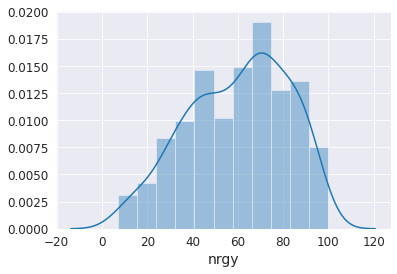

In [24]:
import seaborn as sns
color= sns.color_palette()
sns.set_style('darkgrid')
sns.distplot(regression_train.nrgy)
plt.show()

### Further Correlations

> Below we will use the standard correlation coefficient (Pearson's r) between every pair of attributes compared to 'popularity', with the corr() method:

> Standard correlation coefficient calculates strength of linear relationship:
    * close to +1 it indicates a strong positive correlation
    * close to -1 means a strong negative one

In [25]:
corr_matrix= regression_train.corr()
corr_matrix
corr_matrix['pop'].sort_values(ascending=False)

pop      1.000000
dur      0.363266
dB       0.316854
nrgy     0.303797
dnce     0.258670
spch     0.130955
Id       0.086837
bpm      0.055024
val     -0.018713
live    -0.051364
year    -0.054293
acous   -0.465875
Name: pop, dtype: float64

> So from above, we can notice that popularity has strong positive linear relationship with: duration, loudness (dB), energy and danceability (and in lower degree with speechiness)

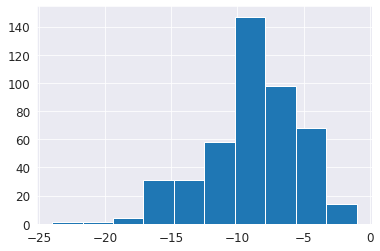

In [26]:
# histogram of loudness

regression_train['dB'].hist()

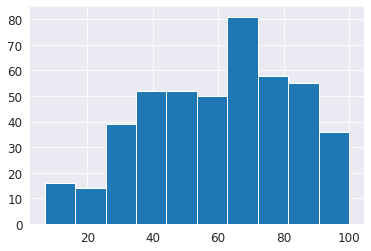

In [27]:
# Histogram of energy

regression_train['nrgy'].hist()

<function matplotlib.pyplot.show>

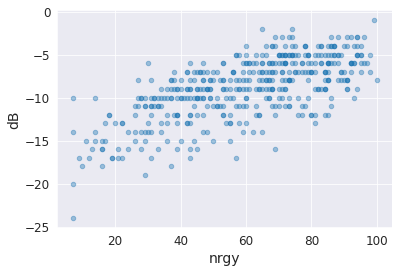

In [28]:
#scatter plot between energy and loudness which seem to be important indicators for song's popularity

regression_train.plot(kind='scatter', x='nrgy', y='dB', alpha=0.4)
plt.show

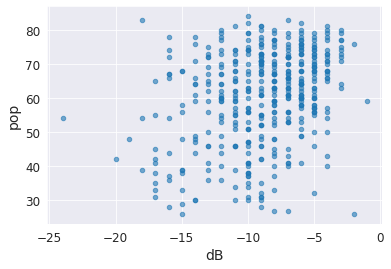

In [29]:
# alpha for transparency
regression_train.plot(kind='scatter', x= 'dB', y='pop', alpha=0.6)
plt.show()

## Preparing the data for machine learning algorithms

> Calling the isolated dataframe as: 'spotify'

In [30]:
spotify= regression_train.drop('pop', axis=1) # isolating the target which is 'pop'
spotify_labels= regression_train['pop'].copy()               # target variable/label is 'pop'

### Data Cleaning

###  Feature Engineering: feature selection

In [31]:
spotify = spotify[['top genre', 'nrgy', 'dnce', 'dB', 'dur']] # the final train predictos we are keeping


In [32]:
spotify.shape

(453, 5)

> Most ML algorithms cannot work with missing features so this is an important step:

In [33]:
spotify.isnull().any()

top genre     True
nrgy         False
dnce         False
dB           False
dur          False
dtype: bool

In [34]:
spotify.isnull().sum()

top genre    15
nrgy          0
dnce          0
dB            0
dur           0
dtype: int64

> We can view the 15 missing values in the column 'top genre'

In [35]:
missing_values_regr= spotify[spotify.isnull().any(axis=1)]
missing_values_regr

,top genre,nrgy,dnce,dB,dur
1,NaN,44,53,-8,139
8,NaN,14,29,-10,143
26,NaN,16,57,-16,181
72,NaN,53,48,-9,135
90,NaN,29,70,-15,172
98,NaN,60,41,-8,170
220,NaN,29,49,-10,118
252,NaN,38,65,-8,146
265,NaN,62,62,-7,120
266,NaN,90,41,-8,273


> Replacing those with 'adult standards', as in exploration of the dataset it was the most famous top genre and, thus, it seems to be one good choice:

In [36]:
spotify['top genre'].fillna(value='adult standards',inplace=True)

In [37]:
spotify.isnull().sum()

top genre    0
nrgy         0
dnce         0
dB           0
dur          0
dtype: int64

> Below we are going to use 'SimpleImputer' which can handle the missing values. Based on the way we going to fill its parameters, we are going to specify how we want to handle the missing values in the unseed data (test data):

Although in this dataset we can know that we have missing values only in top genre in test data (as we will see below), we are continuing this way for the generalisation of the model. If the test data had missing numerical values, then they would be filled by the median value:

In [38]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [39]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   top genre  453 non-null    object
 1   nrgy       453 non-null    int64 
 2   dnce       453 non-null    int64 
 3   dB         453 non-null    int64 
 4   dur        453 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 17.8+ KB


In [40]:
spotify_num= spotify.drop(['top genre'], axis=1) #the numerical attributes

In [41]:
spotify_num

,nrgy,dnce,dB,dur
0,31,45,-8,150
1,44,53,-8,139
2,36,63,-9,245
3,28,47,-16,232
4,47,56,-8,193
...,...,...,...,...
448,22,18,-17,214
449,81,53,-13,147
450,55,73,-8,289
451,87,64,-5,191


In [42]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   top genre  453 non-null    object
 1   nrgy       453 non-null    int64 
 2   dnce       453 non-null    int64 
 3   dB         453 non-null    int64 
 4   dur        453 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 17.8+ KB


In [43]:
imputer.fit(spotify_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [44]:
imputer.statistics_

array([ 63.,  61.,  -8., 223.])

In [45]:
spotify_num.median().values

array([ 63.,  61.,  -8., 223.])

In [46]:
X = imputer.transform(spotify_num)

In [47]:
spotify_tr = pd.DataFrame(X, columns=spotify_num.columns,
                          index=spotify.index)

In [48]:
imputer.strategy

'median'

In [49]:
spotify_tr = pd.DataFrame(X, columns=spotify_num.columns,
                          index=spotify_num.index)
spotify_tr.head(2)
# a sample of how inputer works

,nrgy,dnce,dB,dur
0,31.0,45.0,-8.0,150.0
1,44.0,53.0,-8.0,139.0


In [50]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   top genre  453 non-null    object
 1   nrgy       453 non-null    int64 
 2   dnce       453 non-null    int64 
 3   dB         453 non-null    int64 
 4   dur        453 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 17.8+ KB


In [51]:
# categorical attributes which we will hold for the construction of the model
categorical_attribute= spotify[['top genre']]

> Process for using OneHoTencoder for converting categorical into numerical values:

In [52]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
spotify_cat_encoded = ordinal_encoder.fit_transform(categorical_attribute)
spotify_cat_encoded[:5]

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [68.]])

In [53]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
spotify_cat_hot1 = cat_encoder.fit_transform(categorical_attribute)
spotify_cat_hot1

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

> Machine Learning Algorithms do not perform well when the input numerical attributes have different scales. Below we are going to scale the numerical attributes, and construct a pipeline which can link the tranformations both of numerical and categorical values in the test set:

In [55]:
# We create the preprocessing pipelines for both numerical and categorical data
# credits to: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
# we are using the 'most frequent' strategy with the rational that out categorical attributes are
# very possible to be repeated as the song becomes more popular (one popular singer might own many popular songs in the test set)
numeric_features = list(spotify_num)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = list(categorical_attribute)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

full_pipeline = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

spotify_final= full_pipeline.fit_transform(spotify) #spofify_final : final and transformed train predictors-features

> OneHotEncoder returns a sparse matrix while num_pipeline a dense matrix. In this case of mixing the numerical with categorical transformations, ColumnTransformer returns either a sparse or a dense matrix. Here it returned a sparse matrix:

In [56]:
spotify_final

<453x90 sparse matrix of type '<class 'numpy.float64'>'
	with 2265 stored elements in Compressed Sparse Row format>

In [57]:
# we can convert to an array if needed: spotify_final= spotify_final.toarray()

# Linear Regression

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
lin_reg= LinearRegression()
lin_reg.fit(spotify_final, spotify_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Root Mean Square Error (RMSE)

> Measures the standard deviation of the errors the systems makes in its predictions:

In [60]:
from sklearn.metrics import mean_squared_error
spotify_predictions= lin_reg.predict(spotify_final)

>> The interval of popularity scores (from the data exploration) was between 26 and 84. Here RMSE is 9.27. We could say it not a bad result, but neither a good one:

In [61]:
lin_mse = mean_squared_error(spotify_labels, spotify_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

9.271409734513767

> Using r2_score to conclude if the dataset is linear. If close to 1, the dataset is linear by nature. Here it is not negative, but it has not a high value neither:

In [62]:
from sklearn.metrics import r2_score
r2_score(spotify_predictions, spotify_labels)

0.09596316070850863

### MAE

> Calculating the Mean Absolute Error (MAE), which is smaler than that of the RMSE, since RMSE raises the errors to its square values

In [63]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(spotify_labels, spotify_predictions)
lin_mae

6.998398864900028

## Training a Decision Tree Regressor

In [64]:
from sklearn.tree import DecisionTreeRegressor

tree_reg= DecisionTreeRegressor(random_state=42)
tree_reg.fit(spotify_final, spotify_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [65]:
spotify_predictions = tree_reg.predict(spotify_final)
tree_mse = mean_squared_error(spotify_labels, spotify_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

> Obviously this cannot be a valid result and this model is extremely overfitting the data

>> Evaluation of Decision tree using Cross-Validation with K-folds = 10:

In [66]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, spotify_final, spotify_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)
# the scoring function is the opposite of the MSE so that's why we use '-scores'
tree_rmse_scores

array([15.94760443, 13.24189662, 16.09347694, 16.98365227, 15.43084933,
       15.99791653, 13.40480842, 14.57089946, 16.77696834, 11.39395551])

In [67]:
def display_tree_scores(tree_scores):
    print("Scores:", tree_scores)
    print("Mean:", tree_scores.mean())
    print("Standard deviation:", tree_scores.std())

display_tree_scores(tree_rmse_scores)

Scores: [15.94760443 13.24189662 16.09347694 16.98365227 15.43084933 15.99791653
 13.40480842 14.57089946 16.77696834 11.39395551]
Mean: 14.984202785724648
Standard deviation: 1.7084601132034862


> Here we can see than DecisionTreeRegressor is performing much worse than linear regression 

> Below it is an effort to change decision tree's parameters. Decision Trees are prone to overfitting when dealing with regression tasks, for this reason we set min_samples_leaf=10, and max_depth=1 which gave better results than the default.

>> It performs better than the previous DecisionTreeRegressor, however the final result is still not satisfactory.

In [68]:
from sklearn.tree import DecisionTreeRegressor
tree_reg= DecisionTreeRegressor( random_state=42, min_samples_leaf=10, max_depth=1)
tree_reg.fit(spotify_final, spotify_labels)



DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [69]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, spotify_final, spotify_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)
# the scoring function is the opposite of the MSE so that's why we use '-scores'
tree_rmse_scores

array([13.03497615, 10.79426206, 10.19277763, 11.5861052 , 10.40096828,
       11.92517844, 12.06441073, 11.89422954, 13.55243587, 10.74488677])

In [70]:
def display_tree_scores(tree_scores):
    print("Scores:", tree_scores)
    print("Mean:", tree_scores.mean())
    print("Standard deviation:", tree_scores.std())

display_tree_scores(tree_rmse_scores)

Scores: [13.03497615 10.79426206 10.19277763 11.5861052  10.40096828 11.92517844
 12.06441073 11.89422954 13.55243587 10.74488677]
Mean: 11.619023067905678
Standard deviation: 1.0523359813729696


## Evaluation in the Test Set

In [71]:
regression_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         114 non-null    int64 
 1   title      114 non-null    object
 2   artist     114 non-null    object
 3   top genre  113 non-null    object
 4   year       114 non-null    int64 
 5   bpm        114 non-null    int64 
 6   nrgy       114 non-null    int64 
 7   dnce       114 non-null    int64 
 8   dB         114 non-null    int64 
 9   live       114 non-null    int64 
 10  val        114 non-null    int64 
 11  dur        114 non-null    int64 
 12  acous      114 non-null    int64 
 13  spch       114 non-null    int64 
dtypes: int64(11), object(3)
memory usage: 12.6+ KB


> Sychronizing the test's shape with that of the train set:

In [72]:
x= regression_test[['top genre','nrgy', 'dnce', 'dB', 'dur']] # test predictors

In [73]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   top genre  113 non-null    object
 1   nrgy       114 non-null    int64 
 2   dnce       114 non-null    int64 
 3   dB         114 non-null    int64 
 4   dur        114 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 4.6+ KB


In [74]:
x.isnull().any()

top genre     True
nrgy         False
dnce         False
dB           False
dur          False
dtype: bool

> For example this command: "x['top genre'].fillna(value='adult standards',inplace=True)" is not needed to be executed because of the aforementioned pipeline transformations. If executed then the warning is: "A value is trying to be set on a copy of a slice from a DataFrame".

> Running the full pipeline to tranform the test data.
>> Before we used 'fit_transform', now we are calling only 'transform' for the successfull transition:

In [75]:
x_final=full_pipeline.transform(x)

>The number of rows is normal to be different and it depends on the initial split which was 80%-20% between train and test set. The number of columns are transformed because of the previous steps, but the important here is that both train and test predictors to have the same number of columns (the given inputs compared to the unseen data of test set):

In [76]:
x_final.shape

(114, 90)

In [77]:
spotify_final.shape

(453, 90)

In [78]:
pop_predictions= lin_reg.predict(x_final)

In [79]:
pop_predictions 

array([65.47115059, 67.82500407, 64.59485067, 59.82929431, 56.24957838,
       66.74415382, 50.56053378, 50.35223986, 66.53265246, 64.25067588,
       45.26723827, 66.19277286, 50.85687835, 52.27489538, 66.41541264,
       65.74946224, 67.09551863, 62.70505586, 68.94817651, 65.98060976,
       59.13883178, 51.03545442, 51.80581303, 51.93647478, 57.96989272,
       67.08753045, 63.50064894, 52.22031301, 46.17497965, 71.93750145,
       64.81888251, 54.32110903, 72.31544441, 68.53485624, 67.71063956,
       68.61070154, 69.12051653, 49.78025539, 59.84684013, 62.21213027,
       66.74145484, 69.76256305, 63.61872941, 45.80555405, 56.19653654,
       44.8149961 , 68.83505956, 63.85638796, 53.78650565, 64.88889052,
       51.6179051 , 71.99310683, 70.16929697, 51.31857252, 65.77876081,
       56.59912879, 68.51277649, 51.98576602, 68.44588187, 55.86267857,
       56.08194473, 55.46858362, 68.40855169, 60.91817892, 58.86986711,
       67.00655501, 59.2434269 , 50.05338266, 69.15518279, 69.40

>Exporting the results of 'pop' and 'Id' into a csv file:

In [80]:
len(list(regression_test['Id']))

114

In [81]:
len(list(pop_predictions))

114

In [82]:
regr_results= pd.DataFrame({'Id': regression_test['Id'], 'pop': pop_predictions})
#regr_results

In [83]:
#regr_results.to_csv('GroupN.csv', index = False)

In [84]:
len(regr_results)

114

### Random Forest Regressor

In [85]:
from sklearn.ensemble import RandomForestRegressor
forest_reg= RandomForestRegressor()
forest_reg.fit(spotify_final, spotify_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [86]:
pop_predictions = forest_reg.predict(spotify_final)
forest_mse = mean_squared_error(spotify_labels, pop_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

4.269814865371503

> The ForestRegressor is overfitting the test data, since the RMSE in test set was approximately double reaching 8.45 (the model is performing better in training that in test data)

In [87]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest_reg, spotify_final, spotify_labels,
                         scoring="neg_mean_squared_error", cv=10)

forest_reg_scores = np.sqrt(-scores)
# the scoring function is the opposite of the MSE so that's why we use '-scores'
forest_reg_scores
def display_forest_reg_scores(forest_reg_scores):
    print("Scores:", forest_reg_scores)
    print("Mean:", forest_reg_scores.mean())
    print("Standard deviation:", forest_reg_scores.std())

display_forest_reg_scores(forest_reg_scores)



Scores: [12.22328907 10.13028627 11.19988839 11.19999732 12.68759009 12.33413241
 10.69241548 11.23524613 12.10848472 10.7357164 ]
Mean: 11.454704628505288
Standard deviation: 0.7963436548969758


In [88]:
model_rfr= RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
model_rfr.fit(spotify_final,spotify_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=16,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [89]:
pop_predictions_rfr= model_rfr.predict(x_final)
#pop_predictions_rfr

In [90]:
regr_results_rfr= pd.DataFrame({'Id': regression_test['Id'], 'pop': pop_predictions_rfr})
#regr_results_rfr 


In [91]:
#regr_results_rf= pd.DataFrame({'Id': regression_test['Id'], 'pop': pop_predictions_rfr})
#regr_results_rf 
#regr_results_rf.to_csv('rf.csv', index = False) #### RMSE 8.45 in test set

> Combining Random Forest Regressor with grid search for detecting the best estimator:

In [92]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(spotify_final, spotify_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [93]:
#best hyperparameter
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [94]:

grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [95]:
# score of each hyperparameter combination tested during the grid search

In [96]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

12.383219353522529 {'max_features': 2, 'n_estimators': 3}
11.217887381935927 {'max_features': 2, 'n_estimators': 10}
11.005143365313957 {'max_features': 2, 'n_estimators': 30}
12.947205027731584 {'max_features': 4, 'n_estimators': 3}
11.223663080412425 {'max_features': 4, 'n_estimators': 10}
10.913136155835995 {'max_features': 4, 'n_estimators': 30}
12.3015220763169 {'max_features': 6, 'n_estimators': 3}
11.150914229617594 {'max_features': 6, 'n_estimators': 10}
10.955388378656467 {'max_features': 6, 'n_estimators': 30}
12.716829105732653 {'max_features': 8, 'n_estimators': 3}
11.412339550552026 {'max_features': 8, 'n_estimators': 10}
10.94525161796656 {'max_features': 8, 'n_estimators': 30}
12.733066036739569 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
11.516903765523196 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
12.361887218230702 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
11.502305932213844 {'bootstrap': False, 'max_features': 3, 'n_es

In [97]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(spotify_final, spotify_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [98]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

10.932137346512953 {'max_features': 7, 'n_estimators': 180}
11.247992606446317 {'max_features': 5, 'n_estimators': 15}
10.928962335334413 {'max_features': 3, 'n_estimators': 72}
11.14283989129418 {'max_features': 5, 'n_estimators': 21}
10.979555482164821 {'max_features': 7, 'n_estimators': 122}
10.917924974725016 {'max_features': 3, 'n_estimators': 75}
10.899092779911264 {'max_features': 3, 'n_estimators': 88}
11.057461974193934 {'max_features': 5, 'n_estimators': 100}
10.86414888934659 {'max_features': 3, 'n_estimators': 150}
13.48305317176799 {'max_features': 5, 'n_estimators': 2}


In [99]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.61648540e-01, 1.44375315e-01, 1.22679350e-01, 2.58018520e-01,
       9.44003140e-04, 3.64759827e-02, 3.68142749e-03, 3.65187539e-03,
       1.49905537e-02, 3.74416418e-03, 9.38764523e-05, 9.47993495e-04,
       1.05670991e-03, 8.36366995e-03, 6.51774747e-03, 2.92896925e-04,
       7.50615245e-03, 1.55081173e-03, 5.20038272e-03, 7.42769640e-04,
       4.75156121e-03, 1.25623837e-04, 6.05366613e-04, 1.01618924e-03,
       1.48041365e-03, 3.51050320e-03, 3.00897240e-03, 2.17709908e-04,
       2.35593547e-03, 2.41891240e-02, 1.69273023e-04, 4.88611110e-03,
       1.11909107e-03, 3.92162431e-03, 1.94086349e-03, 1.70971946e-02,
       2.10892931e-03, 7.94692824e-04, 1.07677325e-03, 5.96499707e-04,
       1.38486837e-03, 1.18973680e-03, 7.05575346e-04, 1.12750588e-03,
       2.45686561e-03, 1.07856207e-03, 2.07002450e-03, 1.54262493e-03,
       1.08461217e-04, 5.34840438e-04, 1.23894697e-03, 2.81676267e-03,
       3.04296598e-03, 3.55826766e-04, 1.92413749e-03, 1.52433911e-02,
      

In [100]:
grid_model = grid_search.best_estimator_

grid_model = grid_search.best_estimator_
x_final=full_pipeline.transform(x)
pop_predictions_grid= grid_model.predict(x_final)


In [101]:
#pop_predictions_grid

In [102]:
regr_results_grid= pd.DataFrame({'Id': regression_test['Id'], 'pop': pop_predictions_grid})
#regr_results_grid 
#****************************************************************************************************
#****************************************************************************************************
## 8.11
#regr_results_grid.to_csv('gr.csv', index = False)

### Stochastic Gradient Descent (SGD) Regressor

> Gradient Descent is a different way of training a linear regression model, which is better suited for cases where there is a large number of features or too many training instances to fit in memory. Here, none of these hold true, however, we are going to try it:

> The main idea here is to tweak SGD's parameters iteratively in order to minimise the cost function.

>> Performing SGD linear regression using SGDRegressor(): maximum epochs= 1000, or until the loss drops less than 0.001 (eta=1e-3), default learning scedule, does not use regularisation (penalty=none) and learning rate "η"(eta)=0.1

In [103]:
from sklearn.linear_model import SGDRegressor
sgd_regressor= SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_regressor.fit(spotify_final, spotify_labels)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [104]:
sgd_pop_predictions= sgd_regressor.predict(x_final)

> As we can notice (rmse in test data=16.88) SGD is not appropriate here

In [105]:

#regr_results= pd.DataFrame({'Id': regression_test['Id'], 'pop': sgd_pop_predictions})
#regr_results 
#regr_results.to_csv('-&-.csv', index = False)
#rmse = 16.88

### Polynomial Features

In [106]:
from sklearn.preprocessing import PolynomialFeatures
poly_features= PolynomialFeatures(degree=2, include_bias=False)
X_poly= poly_features.fit_transform(spotify_final)

In [107]:
lin_reg=LinearRegression()
lin_reg.fit(X_poly, spotify_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [108]:
Y_poly= poly_features.fit_transform(x_final)

In [109]:
poly_pop_predictions= lin_reg.predict(Y_poly)

> As exprected, using high-degree polynomial would not prevent the training data from overfitting the test data

In [110]:
#regr_results= pd.DataFrame({'Id': regression_test['Id'], 'pop': poly_pop_predictions})
#regr_results 
#regr_results.to_csv('dwe.csv', index = False)
# rmse = 16.23

### SVM Linear Regression

> SVM in general can perform linear and non-linear regression, classification and outlier detection. 

>> C: hyperparameter of the model

Using Support Vector Regressor with kerner='linear':


In [111]:
from sklearn.svm import SVR
svm_reg = SVR(kernel="linear")
svm_reg.fit(spotify_final, spotify_labels)
pop_predictions = svm_reg.predict(spotify_final)
svm_mse = mean_squared_error(spotify_labels, pop_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

11.068332226463323

Setting epsilon=1.5.Epsilon specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value

In [112]:
from sklearn.svm import LinearSVR

svm_reg= LinearSVR(epsilon=1.5, random_state=42)

svm_reg.fit(spotify_final, spotify_labels)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [113]:
svm_pop_predictions= svm_reg.predict(x_final)

In [114]:
regr_results= pd.DataFrame({'Id': regression_test['Id'], 'pop': svm_pop_predictions})
#regr_results 
#regr_results.to_csv('-&-.csv', index = False)
#rmse = 8.84!! but still is < 8.11 of grid search

In [115]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_reg, spotify_final, spotify_labels,
                         scoring="neg_mean_squared_error", cv=10)

svm_reg_scores = np.sqrt(-scores)
# the scoring function is the opposite of the MSE so that's why we use '-scores'
svm_reg_scores
def display_svm_reg_scores(svm_reg_scores):
    print("Scores:", svm_reg_scores)
    print("Mean:", svm_reg_scores.mean())
    print("Standard deviation:", svm_reg_scores.std())

display_svm_reg_scores(svm_reg_scores)

Scores: [12.36296705 10.25967568 10.28127194  9.37452668 11.86417118 13.69392283
 12.51262187 11.35382883 13.77837387 11.52250564]
Mean: 11.70038655662791
Standard deviation: 1.3808940879572456


In [116]:
svm_reg= LinearSVR(epsilon=1.5, random_state=42, C=12)

svm_reg.fit(spotify_final, spotify_labels)
svm_pop_predictions= svm_reg.predict(x_final)

> Cross Evaluation using cross_val_svore

In [117]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_reg, spotify_final, spotify_labels,
                         scoring="neg_mean_squared_error", cv=10)

svm_reg_scores = np.sqrt(-scores)
# the scoring function is the opposite of the MSE so that's why we use '-scores'
svm_reg_scores
def display_svm_reg_scores(svm_reg_scores):
    print("Scores:", svm_reg_scores)
    print("Mean:", svm_reg_scores.mean())
    print("Standard deviation:", svm_reg_scores.std())

display_svm_reg_scores(svm_reg_scores)



Scores: [11.88359404 10.24226385 11.92752877  8.08302455 12.39766512 14.15652718
 11.33030857 10.32086725 12.3463123  11.33984073]
Mean: 11.402793233150796
Standard deviation: 1.5335266282555353


In [118]:
regr_results= pd.DataFrame({'Id': regression_test['Id'], 'pop': svm_pop_predictions})
#regr_results 
#regr_results.to_csv('-&-.csv', index = False)

#***************************************************************************************************************
#rmse = 7.86967 So far the 2nd best model 
#***************************************************************************************************************

### LinearSVR with an RBF kernel
> Using randomised search with cross validation to find the appropriate hyperparameter values for C and gamma:

In [119]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(spotify_final, spotify_labels)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [120]:
pop_pred=lin_svr.predict(x_final)
#len(pop_pred)

In [121]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 15)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(spotify_final, spotify_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=6.618101782710437, gamma=0.07969454818643928 ..................
[CV] ... C=6.618101782710437, gamma=0.07969454818643928, total=   0.0s
[CV] C=6.618101782710437, gamma=0.07969454818643928 ..................
[CV] ... C=6.618101782710437, gamma=0.07969454818643928, total=   0.0s
[CV] C=6.618101782710437, gamma=0.07969454818643928 ..................
[CV] ... C=6.618101782710437, gamma=0.07969454818643928, total=   0.0s
[CV] C=11.979909127171076, gamma=0.015751320499779724 ................
[CV] . C=11.979909127171076, gamma=0.015751320499779724, total=   0.0s
[CV] C=11.979909127171076, gamma=0.015751320499779724 ................
[CV] . C=11.979909127171076, gamma=0.015751320499779724, total=   0.0s
[CV] C=11.979909127171076, gamma=0.015751320499779724 ................
[CV] . C=11.979909127171076, gamma=0.015751320499779724, total=   0.0s
[CV] C=3.340279606636548, gamma=0.002051110418843397 .................
[CV] .. C=3.3402

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] . C=10.016725176148132, gamma=0.026070247583707663, total=   0.0s
[CV] C=10.016725176148132, gamma=0.026070247583707663 ................
[CV] . C=10.016725176148132, gamma=0.026070247583707663, total=   0.0s
[CV] C=10.016725176148132, gamma=0.026070247583707663 ................
[CV] . C=10.016725176148132, gamma=0.026070247583707663, total=   0.0s
[CV] C=1.3087674144370367, gamma=0.0870602087830485 ..................
[CV] ... C=1.3087674144370367, gamma=0.0870602087830485, total=   0.0s
[CV] C=1.3087674144370367, gamma=0.0870602087830485 ..................
[CV] ... C=1.3087674144370367, gamma=0.0870602087830485, total=   0.0s
[CV] C=1.3087674144370367, gamma=0.0870602087830485 ..................
[CV] ... C=1.3087674144370367, gamma=0.0870602087830485, total=   0.0s
[CV] C=13.486639612006327, gamma=0.0026587543983272693 ...............
[CV]  C=13.486639612006327, gamma=0.0026587543983272693, total=   0.0s
[CV] C=13.486639612006327, gamma=0.0026587543983272693 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b8fa9c320>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b8fa9c0f0>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [122]:
rnd_search_cv.best_estimator_

SVR(C=6.618101782710437, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [123]:
pop_pred = rnd_search_cv.best_estimator_.predict(x_final)

In [124]:
regr_results= pd.DataFrame({'Id': regression_test['Id'], 'pop': pop_pred})
#regr_results 
#regr_results.to_csv('cc.csv', index = False)
#***************************************************************************************************************

# RMSE in test: 7.83639. So far the best model 
#***************************************************************************************************************

In [125]:
spotify_final_dense= spotify_final.toarray()
x_final_dense= x_final.toarray()

### Gradient Boosting Regressor

> Boosting hypothesis refers to any Ensemble method that can combine several weak learners into a strong learner: It works by sequentially adding predictors to an ensemble, each one correcting its predecessor (popular methods: Adaptive Boost, Gradient Boosting). They are both suitable for regression and classification.

> Gradient Boosting Regressor works by adding predictos to an ensemble, each one correcting its predecessor, by fitting the new predictor to the residual errors made by the previous predictor (and not by increasing the relative weight of misclassified training instances as in Adaboost).
>> n_estimators= numbers of trees


>> max_depth, min_samples_leaf: hyperparameters controlling the growth of Desicion Trees

In [126]:
from sklearn.ensemble import GradientBoostingRegressor

gbr= GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1, random_state=42)
gbr.fit(spotify_final_dense, spotify_labels)
pop_predictions_gbr= gbr.predict(x_final_dense)

In [127]:
regr_results= pd.DataFrame({'Id': regression_test['Id'], 'pop': pop_predictions_gbr})
#regr_results 
#regr_results.to_csv('gb.csv', index = False)
#rmse= 8.9

### XGBoost
> Extreme Gradient Boosting (Optimised Implementation of Gradient Boosting)

In [128]:
import xgboost

> It requires dense arrays:

In [129]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(spotify_final_dense, spotify_labels)
pop_predictions_gb= xgb_reg.predict(x_final_dense)

[16:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [130]:
regr_results= pd.DataFrame({'Id': regression_test['Id'], 'pop': pop_predictions_gb})
#regr_results 
#regr_results.to_csv('cc.csv', index = False)
# RMSE= 8.1 

As we can see above, indeed it performed quite better than Gradient Boosting, but still is not the best model overall.

### Reflection on Regression:

Overall, the best models seemed to be: Linear SVM using best estimator (RMSE=7.836 in kaggle's test set) which gave us the best parametres (such as gamma and C) for this model. Xboost Regressor follows reaching 8.1 while Random Forest Regressor along with grid search gave RMSE 8.11.

In many cases the models were overfitting the test data. This can be solved with several ways such as:
- gathering more training data (indeed, this dataset can be considered quite small)
- implementing better feature engineering such as proceeding to better feature selection and/or introducing new columns in the dataset which would reflect potentially important feature relationships.
- Undersampling and removal of outliers and noise
                                                                        
                                                                        